In [1]:
!pip3 install metar --user
!pip3 install -q -U tqdm --user
!pip3 install pyproj==1.9.6 --user
!pip3 install -q -U https://github.com/matplotlib/basemap/archive/master.zip --user
!pip3 install portolan --user
!pip3 install pandas --user

  Using cached https://files.pythonhosted.org/packages/26/8c/1da0580f334718e04f8bbf74f0515a7fb8185ff96b2560ce080c11aa145b/pyproj-1.9.6.tar.gz
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1
  Running setup.py install for pyproj ... done


In [2]:
import re
import datetime
from datetime import date, timedelta
import numpy as np
import pandas as pd
import multiprocessing
from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from metar import Metar

import portolan

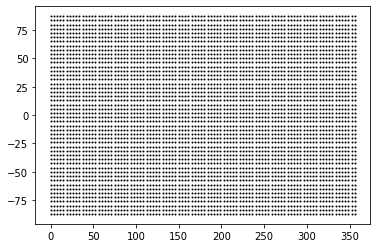

In [3]:
X_speedy_lon = np.linspace(0,360-3.75,96)
Y_speedy_lat = np.array("-87.159 -83.479 -79.777 -76.070 -72.362 -68.652 -64.942 -61.232 -57.521 -53.810 -50.099 -46.389 -42.678 -38.967 -35.256 -31.545 -27.833 -24.122 -20.411 -16.700 -12.989 -9.278 -5.567 -1.856 1.856 5.567 9.278 12.989 16.700 20.411 24.122 27.833 31.545 35.256 38.967 42.678 46.389 50.099 53.810 57.521 61.232 64.942 68.652 72.362 76.070 79.777 83.479 87.159".split(" "))
Y_speedy_lat = Y_speedy_lat.astype(np.float32)

def plot_speedy():
    plt.figure()
    for x in X_speedy_lon:
        for y in Y_speedy_lat:
            plt.plot(x,y,'ko',ms=1);

plot_speedy()

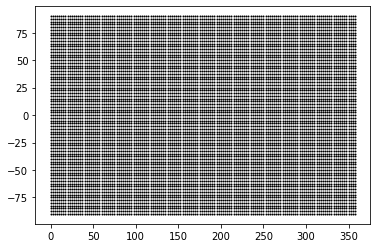

In [4]:
## NOAA latitude goes from North To South
X_noaa_lon = np.linspace(0,360-2.5,144)
Y_noaa_lat = np.linspace(90,-90,73)

def plot_noaa():
    plt.figure()
    for x in X_noaa_lon:
        for y in Y_noaa_lat:
            plt.plot(x,y,'ko',ms=1);

plot_noaa()

In [5]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(['script', 'style']):
            script.extract()
        return soup
    except Exception as e:
        print(e)
        return None


def get_stations_noaa():
    soup = fetch('https://tgftp.nws.noaa.gov/data/observations/metar/stations/')
    stations = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if 'TXT' in href:
            stations.append(href.split('.TXT')[0])
    return stations


def get_stations_with_coords():
    soup = fetch('http://128.117.200.221/surface/stations.txt')
    text = soup.get_text()
    matches = re.findall(r".*([A-Z]{4}).*[\s]([\d]+\s[\d]+\w).*[\s]([\d]+\s[\d]+\w)[\s]*(\d{1,4}).*", text)
    stations = []
    for match in matches:
        stations.append({'ICAO': match[0],
                        'coords': '+'.join(match[1:]).replace(' ', '-'
                        )})
    return stations


In [6]:
df = pd.read_csv('8-9_metar.csv')
df.head()

KeyboardInterrupt: 

In [ ]:
len(df)

In [ ]:
noaa_stations = get_stations_with_coords()

In [ ]:
def gms_to_lat_lng(gms):
  comp = gms.split('-')
  if len(comp)==2:
    if 'N' in comp[1] or 'E' in comp[1]:
      return int(comp[0])+(int(comp[1][:len(comp)])/60)
    else:
      return -(int(comp[0])+(int(comp[1][:len(comp)])/60))
  elif len(comp)==3:
    if 'N' in comp[2] or 'E' in comp[2]:
      return int(comp[0])+(int(comp[1][:len(comp)])/60)+(int(comp[2][:len(comp)-1])/60)
    else:
      comp[2]='0'+comp[2][:len(comp)-1]
      return (-int(comp[0])-(int(comp[1][:len(comp)])/60)-(int(comp[2][:len(comp)-1])/3600))
  else:
    return 0

def nearest_neighbour(X_lng, Y_lat, lng, lat):
    diff_x = 100
    diff_y = 100
    pos_x = 0
    pos_y = 0
    for x in X_lng:
        diff = abs(x - lng)
        if diff_x > diff:
            pos_x = x
            diff_x = diff

    for y in Y_lat:
        diff = abs(y - lat)
        if diff_y > diff:
            pos_y = y
            diff_y = diff
    return (pos_x, pos_y)


In [ ]:
PRESSURE_LEVELS_HEIGHTS_VALUES = [
    762,
    1458,
    3013,
    5576,
    9166,
    11787,
    16000,
]

def wind_comps(obs):
    # ESE at 11 knots
    # WSW at greater than 99 knots
    if 'knots' in obs and 'variable' not in obs:
        compass_point, mag = re.findall(r".*wind:\s(\w+).*([0-9]+)[\s]knots", obs)[0]
        ang = portolan.middle(compass_point)
        mag = int(mag) / 1.944
        u = mag * np.sin(ang)
        v = mag * np.cos(ang)
        return (u, v)
    else:
        return (0, 0)


def month2number(month_name):
    datetime_object = datetime.datetime.strptime(month_name, '%b')
    return datetime_object.month


def parse_datetime(time):
    return datetime.datetime.strptime(time, '%a %b %d %H:%M:%S %Y')

def elev_to_press_level(elev):
    max_diff = 10000
    level = 0
    for (idx, val) in enumerate(PRESSURE_LEVELS_HEIGHTS_VALUES):
        diff = abs(val - elev)
        if max_diff > diff:
            level = idx
            max_diff = diff
    return level

def calculate_rh(dew_point, temp):
    c = 243.04
    b = 17.625
    return 100 * np.exp(c * b * (dew_point - temp) / ((c + temp) * (c + dew_point)))

def parse_pressure(obs):
    # pressure: 1027.8 mb
    # 3-hr pressure change 1.7hPa, increasing, then decreasing
    if 'pressure:' in obs:
        press = float(re.findall(r".*pressure:\s(.*)[\s]mb\s*", obs)[0]) * 100
    else:
        press = float(re.findall(r".*pressure[\s]change[\s](.*)hPa", obs)[0]) * 100
    return press


In [ ]:
idx = 1057228
row = df.iloc[idx]
obs = Metar.Metar(row['observation']).string()
print(obs)
print(row['lat'], row['lng'], row['elev'])
elev_to_press_level(int(elev))

In [ ]:
lati = []
lngt = []
lati2 = []
lngt2 = []
dataexport=[]
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    lati.append(gms_to_lat_lng(lat))
    lngt.append(gms_to_lat_lng(lng))
    nombreEstacion=station['ICAO']
    dataexport.append([nombreEstacion,gms_to_lat_lng(lat),gms_to_lat_lng(lng),elev])
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
plt.legend()
plt.savefig('estaciones.jpg', dpi=600)
plt.show()

for stat in obs_cords:
    lati2.append(stat[0])
    lngt2.append(stat[1])
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('estaciones2.jpg', dpi=600)
plt.show()

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('estaciones3.jpg', dpi=600)
plt.show()


In [ ]:
plot_speedy()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in tqdm(obs_cords):
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


In [ ]:
plot_noaa()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in tqdm(obs_cords):
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


In [ ]:
obs_df['datetime'] = pd.to_datetime(obs_df.datetime)
obs_df = obs_df.sort_values(by='datetime')

obs_df.head()

In [ ]:
obs_df.tail()

In [ ]:
# obs_df (df to read)
sdate = obs_df.iloc[0]['datetime']
delta = (obs_df.iloc[-1]['datetime'] - sdate)
hours = ['00','06','12','18']

dt = []

def parse_metars(idx):
    row = obs_df.iloc[idx]
    if row['datetime'].hour == 0 || row['datetime'].hour == 6 || row['datetime'].hour == 12
        || row['datetime'].hour == 18: 
        try:  
            obs = Metar.Metar(row['observation']).string()

            if ('temperature' in obs):
                temp = float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0])
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'air', temp])

            (u, v) = wind_comps(obs)
            if (u, v) != (0,0):
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'uwnd', u])
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'vwnd', v])

            # pA
            if ('pressure' in obs):
                press = parse_pressure(obs)
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'press', press])
            
            if ('dew point' in obs and 'temperature' in obs):
                dew_point = float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*", obs)[0])
                rh = calculate_rh(dew_point, temp)
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'rhum', rh])
            
        except Exception as e:
            str_err = str(e)
            if 'Unparsed groups' not in str_err and '_handleTime' not in str_err and '_handleWind' not in str_err and "NSW" not in str_err:
                print('index:', idx, 'error:', e)

In [ ]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(parse_metars, range(len(obs_df)))